# Word To Vec and p2Vmaps

In [1]:
import os

import common
import gensim  # word2vec (very similar to our product2vec model)
import matplotlib
import matplotlib.pyplot as plt
# plot final map
import numpy as np
import p2vmap
import pandas as pd
import sklearn.manifold  # t-SNE (last step of p2v-map)
import torch  # NN -> our own P2V model
import torch.nn
import torch.nn.functional
from sklearn.decomposition import PCA
from tqdm import tqdm


matplotlib.rcParams["image.cmap"] = "jet"

In [2]:
print(gensim.__version__)

4.1.1


## Input

In [3]:

product = pd.DataFrame(
    {
        "product": list(range(300)),
        "category": np.repeat(range(20), 15),
    }
)

<br>
<br>

## Load configs and data

In [4]:
config_w2v = common.read_yaml("config-w2v.yaml")
config_w2v

{'baskets_df_to_list': {'min_basket_size': 3,
  'shuffle': True,
  'to_string': True,
  'seed': 123},
 'Word2Vec': {'vector_size': 15,
  'window': 2000,
  'min_count': 1,
  'alpha': 0.025,
  'min_alpha': 0.0001,
  'sample': 0.001,
  'sg': 1,
  'negative': 20,
  'epochs': 3,
  'compute_loss': False,
  'workers': 1,
  'seed': 1},
 'TSNE': {'n_components': 2,
  'n_iter': 4000,
  'perplexity': 5,
  'init': 'pca',
  'angle': 0.5,
  'random_state': 123,
  'verbose': 0},
 'MDS': {'n_components': 2,
  'max_iter': 4000,
  'random_state': 123,
  'verbose': 0}}

In [5]:
baskets = pd.read_parquet("market-baskets.parquet")
del baskets["customer"]
baskets.head()

,product,basket
0,51,00000000
1,113,00000000
2,154,00000000
3,165,00000000
4,185,00000000


<br>
<br>

## P2V-MAP based on `gensim`

### Produce basket list

In [6]:
baskets.head(20)

,product,basket
0,51,00000000
1,113,00000000
2,154,00000000
3,165,00000000
4,185,00000000
5,253,00000000
6,266,00000000
7,31,00000001
8,67,00000001
9,248,00000001


In [7]:
baskets['product'].value_counts()

198    30363
165    28777
110    28691
107    28690
128    28492
       ...  
58     12858
131    12539
295    12442
114    12193
170    10366
Name: product, Length: 300, dtype: int64

In [8]:
basket_list = p2vmap.baskets_df_to_list(
    x=baskets, **config_w2v["baskets_df_to_list"]
)
basket_list[:2]

[['60', '1', '187'], ['162', '84', '173', '253', '23', '50', '65', '185']]

In [9]:
sum([len(b) for b in basket_list])

6117608

In [10]:
len(basket_list)

969229

In [11]:
basket_list[:2]

[['60', '1', '187'], ['162', '84', '173', '253', '23', '50', '65', '185']]

ini = pairs(basket_list)

### Word2Vec model

In [12]:
config_w2v["Word2Vec"]

{'vector_size': 15,
 'window': 2000,
 'min_count': 1,
 'alpha': 0.025,
 'min_alpha': 0.0001,
 'sample': 0.001,
 'sg': 1,
 'negative': 20,
 'epochs': 3,
 'compute_loss': False,
 'workers': 1,
 'seed': 1}

In [13]:
# p2v: which products (co-)occur in a shopping basket
# w2v: which words (co-)occur in a sentence
#
# this sentence is "which products (co-)occur in a shopping basket."
# ------------------- x ------------------------
#                   window

w2v = gensim.models.Word2Vec(basket_list, **config_w2v["Word2Vec"])


In [14]:
config_w2v["Word2Vec"]
# vector size

{'vector_size': 15,
 'window': 2000,
 'min_count': 1,
 'alpha': 0.025,
 'min_alpha': 0.0001,
 'sample': 0.001,
 'sg': 1,
 'negative': 20,
 'epochs': 3,
 'compute_loss': False,
 'workers': 1,
 'seed': 1}

In [15]:
product_embedding, _, _ = p2vmap.gensim_to_pandas(w2v)
product_embedding.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
product,,,,,,,,,,,,,,,
0,0.831468,-0.177358,0.307734,-1.188986,-0.243754,0.280594,-0.305195,-0.098404,0.296303,0.438191,-0.506709,-0.254565,0.125164,-0.425667,-0.338645
1,0.827167,-0.200450,0.309630,-1.186370,-0.246286,0.259199,-0.322311,-0.090888,0.275197,0.418171,-0.506706,-0.252755,0.104447,-0.451302,-0.348089
2,0.822097,-0.188227,0.318900,-1.185131,-0.283452,0.294623,-0.338352,-0.084405,0.288645,0.405473,-0.495473,-0.225480,0.124647,-0.466606,-0.334185
3,0.849594,-0.164157,0.299520,-1.194917,-0.264515,0.293634,-0.318549,-0.076137,0.293476,0.416339,-0.488352,-0.257414,0.111264,-0.444954,-0.326486
4,0.828894,-0.189301,0.291094,-1.187812,-0.265259,0.275426,-0.313692,-0.097291,0.294718,0.428758,-0.494655,-0.264602,0.098041,-0.437580,-0.372259


In [16]:
# each row is a product vector
x = product_embedding.values
# normalize vectors to unit-length
x /= np.linalg.norm(x, axis=1)[:, np.newaxis]

In [17]:
# cosine similarity of product 0 with itself
x[0, :].dot(x[0, :])

0.9999999

In [18]:
# cosine similarities between the first 5 products
x[0:5, :].dot(x[0:5, :].T)

array([[0.9999998 , 0.9994979 , 0.9989375 , 0.9995033 , 0.99951   ],
       [0.9994979 , 0.99999994, 0.99922967, 0.9992782 , 0.9995917 ],
       [0.9989375 , 0.99922967, 1.0000001 , 0.9993348 , 0.998909  ],
       [0.9995033 , 0.9992782 , 0.9993348 , 1.        , 0.9993326 ],
       [0.99951   , 0.9995917 , 0.998909  , 0.9993326 , 0.9999999 ]],
      dtype=float32)

In [19]:
np.round(x[10:20, :].dot(x[10:20, :].T), 2)

array([[1.  , 1.  , 1.  , 1.  , 1.  , 0.17, 0.18, 0.17, 0.19, 0.17],
       [1.  , 1.  , 1.  , 1.  , 1.  , 0.18, 0.19, 0.18, 0.2 , 0.18],
       [1.  , 1.  , 1.  , 1.  , 1.  , 0.19, 0.21, 0.2 , 0.22, 0.2 ],
       [1.  , 1.  , 1.  , 1.  , 1.  , 0.19, 0.2 , 0.19, 0.21, 0.19],
       [1.  , 1.  , 1.  , 1.  , 1.  , 0.19, 0.2 , 0.19, 0.22, 0.2 ],
       [0.17, 0.18, 0.19, 0.19, 0.19, 1.  , 1.  , 1.  , 1.  , 1.  ],
       [0.18, 0.19, 0.21, 0.2 , 0.2 , 1.  , 1.  , 1.  , 1.  , 1.  ],
       [0.17, 0.18, 0.2 , 0.19, 0.19, 1.  , 1.  , 1.  , 1.  , 1.  ],
       [0.19, 0.2 , 0.22, 0.21, 0.22, 1.  , 1.  , 1.  , 1.  , 1.  ],
       [0.17, 0.18, 0.2 , 0.19, 0.2 , 1.  , 1.  , 1.  , 1.  , 1.  ]],
      dtype=float32)

### Map

In [20]:
x = product_embedding.values  # pd dataframe -> np array
x /= np.linalg.norm(x, axis=1)[:, np.newaxis]  # normalize
res_tsne = sklearn.manifold.TSNE(**config_w2v["TSNE"]).fit_transform(
    x
)  # dimensionality reduction from D (25) -> 2

In [21]:
config_w2v["TSNE"]

{'n_components': 2,
 'n_iter': 4000,
 'perplexity': 5,
 'init': 'pca',
 'angle': 0.5,
 'random_state': 123,
 'verbose': 0}

In [22]:
res_PCA =  PCA(n_components=2, random_state = 123).fit_transform(x)

In [23]:
MDS_tsne = sklearn.manifold.MDS(**config_w2v["MDS"]).fit_transform(x)

In [24]:
tsne_map_xy = pd.DataFrame(
    res_tsne,
    index=product[["category", "product"]].set_index(["category", "product"]).index,
    columns=["x", "y"],
).reset_index()

In [25]:
MDS_map_xy = pd.DataFrame(
    MDS_tsne,
    index=product[["category", "product"]].set_index(["category", "product"]).index,
    columns=["x", "y"],
).reset_index()

In [26]:
PCA_map_xy = pd.DataFrame(
    res_PCA,
    index=product[["category", "product"]].set_index(["category", "product"]).index,
    columns=["x", "y"],
).reset_index()

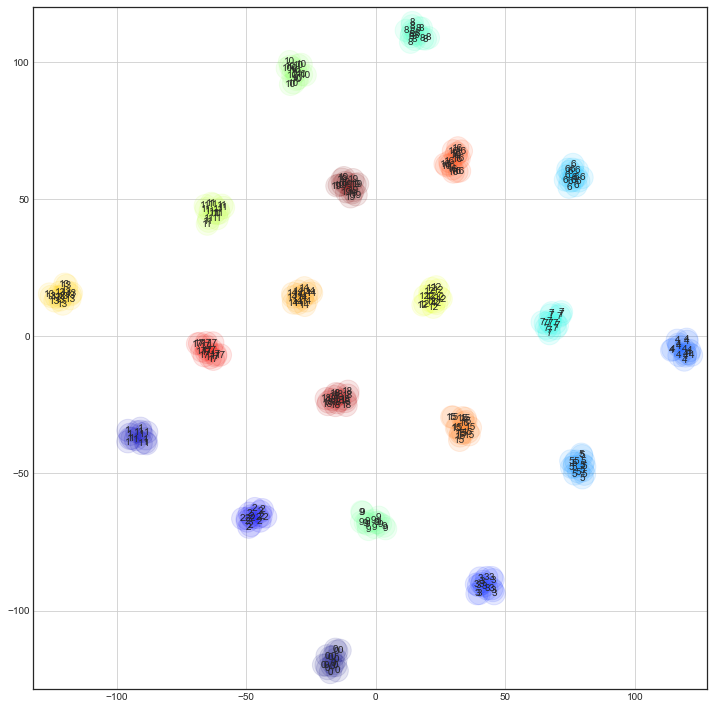

In [27]:
p2vmap.plot_tsne(tsne_map_xy, plotlabels=True, scatter=0)

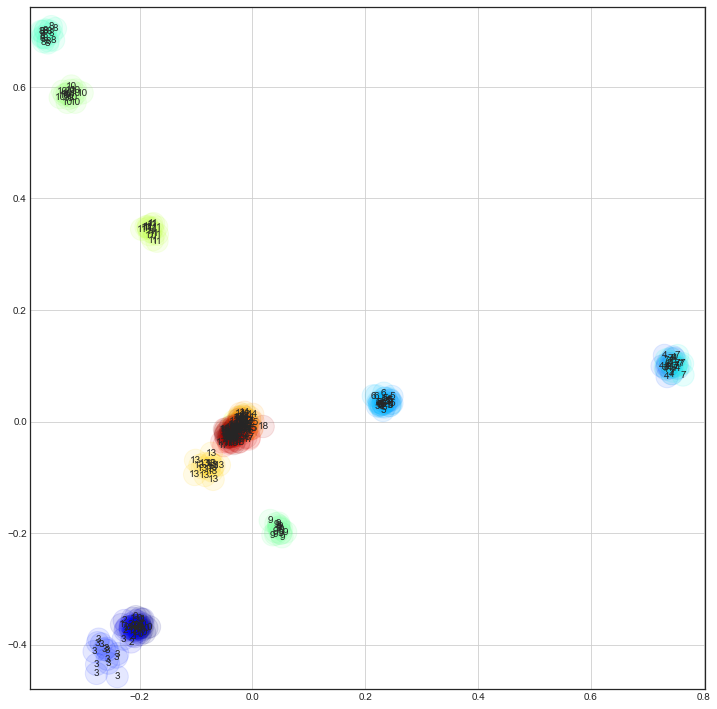

In [28]:
p2vmap.plot_tsne(PCA_map_xy, plotlabels=True, scatter=0)

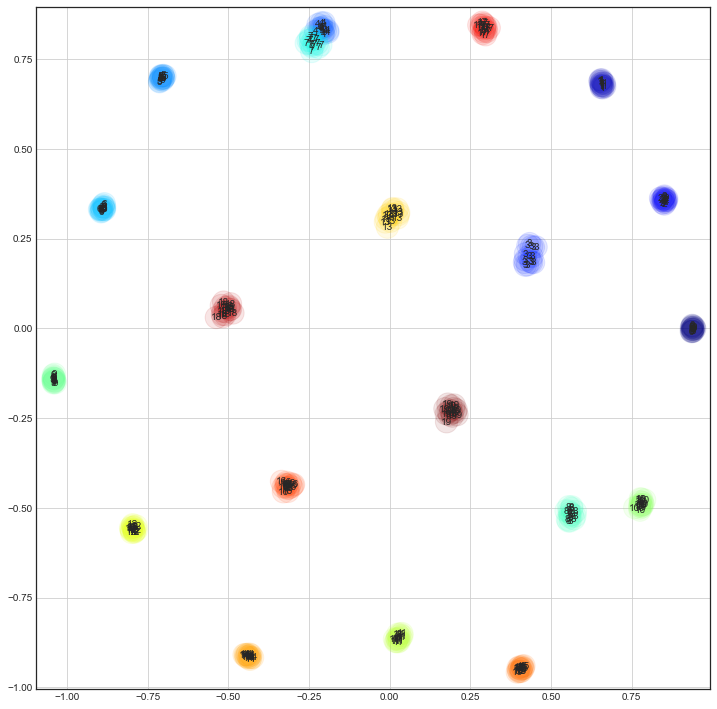

In [29]:
p2vmap.plot_tsne(MDS_map_xy, plotlabels=True, scatter=0)

# Clustering

In [30]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

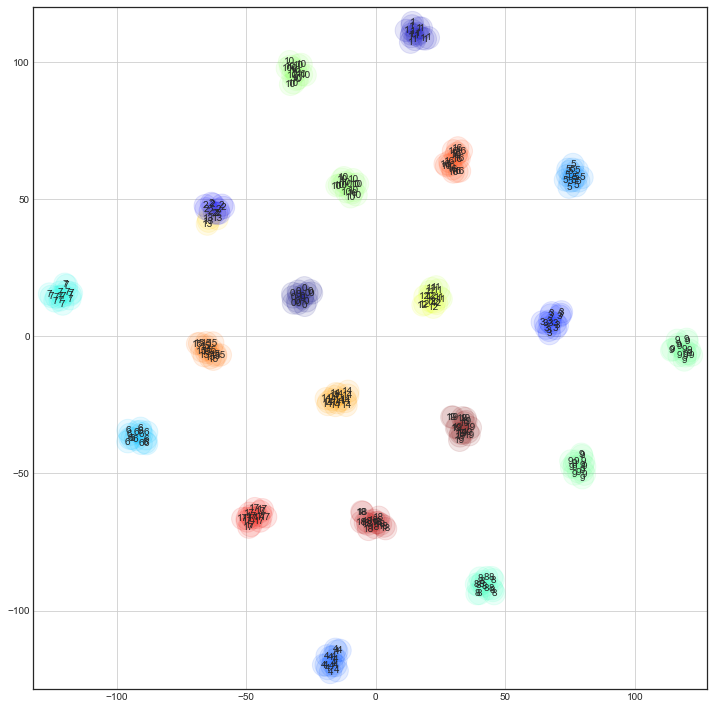

In [31]:
kmeans_kwargs = {
   "init": "random",
    "n_init": 10,
    "max_iter": 300,
   "random_state": 123,
}

tsne_random = tsne_map_xy.sample(frac=1, random_state=123)
kmeans_tsne = KMeans(n_clusters=20, **kmeans_kwargs).fit(tsne_random[['x','y']])
tsne_random['category_prediction'] = kmeans_tsne.labels_

p2vmap.plot_tsne(tsne_random, plotlabels=True, scatter=0,predicted = True)

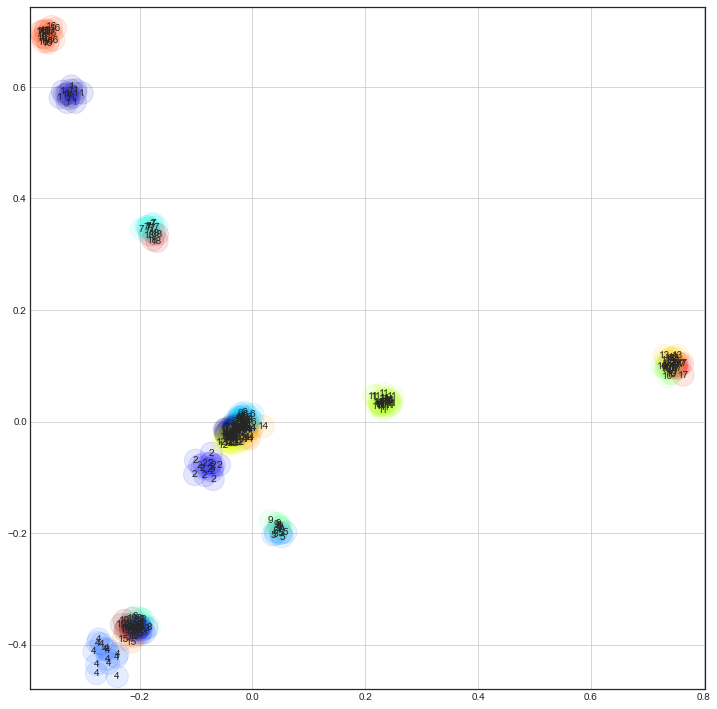

In [32]:

PCA_random = PCA_map_xy.sample(frac=1, random_state=123)
kmeans_PCA = KMeans(n_clusters=20, **kmeans_kwargs).fit(PCA_random[['x','y']])
PCA_random['category_prediction'] = kmeans_PCA.labels_

p2vmap.plot_tsne(PCA_random, plotlabels=True, scatter=0,predicted = True)

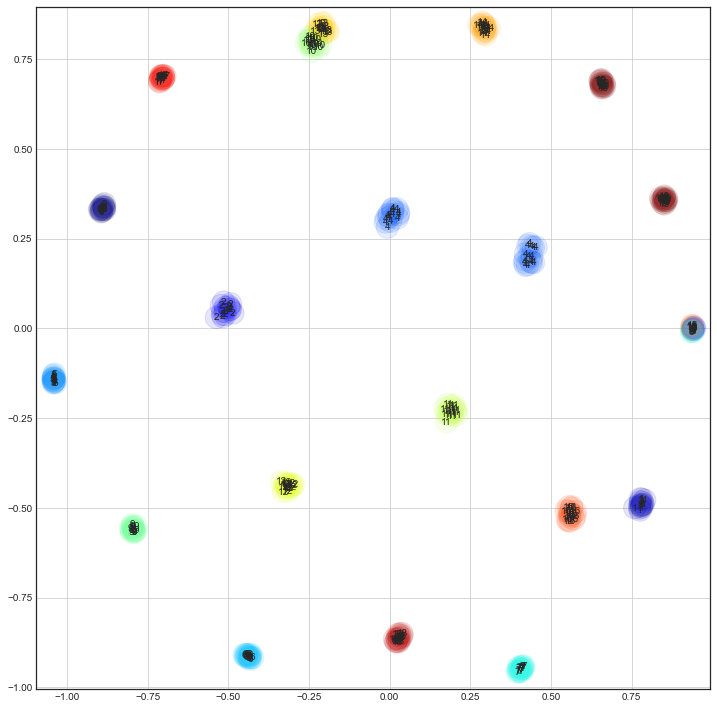

In [33]:

MDS_random = MDS_map_xy.sample(frac=1, random_state=123)
kmeans_MDS = KMeans(n_clusters=20, **kmeans_kwargs).fit(MDS_random[['x','y']])
MDS_random['category_prediction'] = kmeans_MDS.labels_

p2vmap.plot_tsne(MDS_random, plotlabels=True, scatter=0,predicted = True)

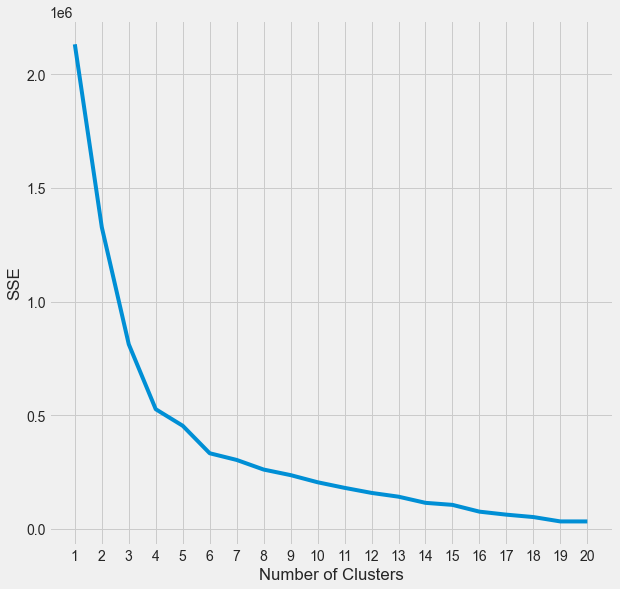

In [34]:
sse = []
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(tsne_map_xy[['x','y']])
    sse.append(kmeans.inertia_)
    
plt.style.use("fivethirtyeight")
plt.plot(range(1, 21), sse)
plt.xticks(range(1, 21))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

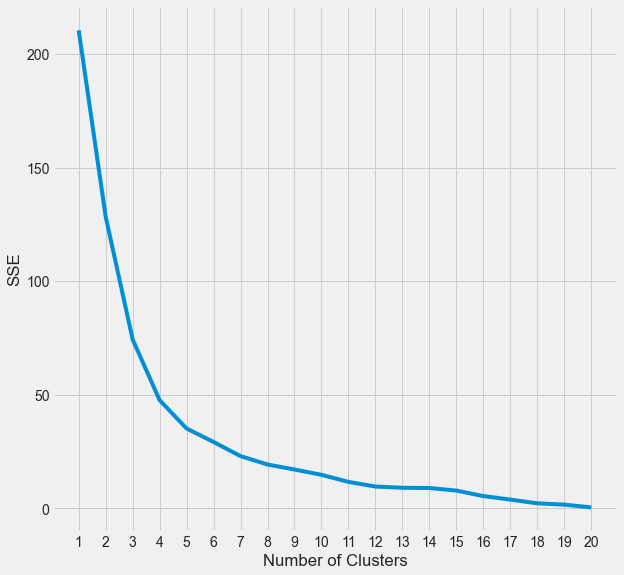

In [35]:
sse = []
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(MDS_map_xy[['x','y']])
    sse.append(kmeans.inertia_)
    
plt.style.use("fivethirtyeight")
plt.plot(range(1, 21), sse)
plt.xticks(range(1, 21))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

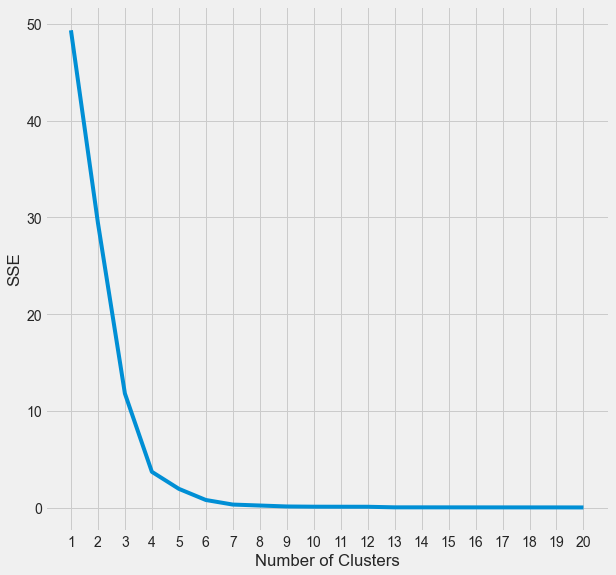

In [36]:
sse = []
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(PCA_map_xy[['x','y']])
    sse.append(kmeans.inertia_)
    
plt.style.use("fivethirtyeight")
plt.plot(range(1, 21), sse)
plt.xticks(range(1, 21))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

# Metrics
## Silhouette Metric

In [37]:
#TSNE
cluster_labels = tsne_map_xy['category']
X =  tsne_map_xy[['x','y']].to_numpy()
sil_skl = sklearn.metrics.silhouette_score(
    X,
    cluster_labels,
)
sil_skl

0.90788007

In [38]:
#PCA
cluster_labels = PCA_map_xy['category']
X =  PCA_map_xy[['x','y']].to_numpy()
sil_skl1 = sklearn.metrics.silhouette_score(
    X,
    cluster_labels,
)
sil_skl1

0.22046492

In [39]:
#MDS
cluster_labels = MDS_map_xy['category']
X =  MDS_map_xy[['x','y']].to_numpy()
sil_skl2 = sklearn.metrics.silhouette_score(
    X,
    cluster_labels,
)
sil_skl2

0.9246318104364794

## Mutual Info Gain

In [40]:
MDS_random

,category,product,x,y,category_prediction
262,17,262,0.299199,0.837548,14
114,7,114,-0.252944,0.802019,10
165,11,165,0.031543,-0.851342,18
278,18,278,-0.509971,0.058097,2
293,19,293,0.206096,-0.226692,11
...,...,...,...,...,...
106,7,106,-0.241878,0.771525,10
83,5,83,-0.701961,0.703378,17
17,1,17,0.661558,0.684393,19
230,15,230,0.407509,-0.948617,7


In [41]:
from sklearn.metrics.cluster import adjusted_mutual_info_score
adjusted_mutual_info_score(MDS_random['category'], MDS_random['category_prediction'])


0.9578883968735467

In [42]:
adjusted_mutual_info_score(PCA_random['category'], PCA_random['category_prediction'])



0.6933447352959797

In [43]:
adjusted_mutual_info_score(tsne_random['category'], tsne_random['category_prediction'])

0.9560552001053214